In [1]:
import os, cv2, glob, gdown, random
import numpy                     as np
import tensorflow                as tf
import matplotlib.pyplot         as plt
from collections             import defaultdict
from keras.callbacks         import EarlyStopping
from sklearn.model_selection import train_test_split

print("Num TPUs Available: ", len(tf.config.list_physical_devices('TPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

2024-10-21 16:44:57.376554: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-21 16:44:57.542382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 16:44:57.608176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 16:44:57.626129: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 16:44:57.758117: I tensorflow/core/platform/cpu_feature_guar

Num TPUs Available:  0
Num GPUs Available:  0
Num CPUs Available:  1


I0000 00:00:1729539902.324396  311719 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-21 16:45:02.488218: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
DATASET_PATH = "./datasets/dataset_v2"
DATASET_PATH_TEST_IMAGE = "./datasets/dataset_v2_specific/A/mpoetza1.pgm"

MODEL_PATH = "./models/model_v2.keras"

QUANTIZED_MODEL_PATH = "./models/quant_model_v2.tflite"

HEX_MODEL_PATH = "./models/hex_model_v2.cc"

Para colab

In [78]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cp -r "/content/drive/MyDrive/datasets/dataset_v4.1.zip" "dataset_v4.1.zip"
# %unzip "content/drive/MyDrive/datasets/dataset_v4.1.zip" -d .
# %clear && ls

# DATASET_PATH = './dataset_v4.1'

# MODELO DE REGRESIÓN LINEAL

## Pre procesamiento

Final dataset:
* Dataset 1: https://www.idiap.ch/webarchives/sites/www.idiap.ch/resource/gestures/ (finalmente no se uso)
* Dataset 2: https://www.kaggle.com/datasets/lexset/synthetic-asl-numbers

In [3]:
dataset_path = os.path.join(DATASET_PATH, '*')
dataset_path = glob.glob(dataset_path)
dataset_path

['./datasets/dataset_v2_specific/Blank',
 './datasets/dataset_v2_specific/One',
 './datasets/dataset_v2_specific/Five',
 './datasets/dataset_v2_specific/A',
 './datasets/dataset_v2_specific/Three',
 './datasets/dataset_v2_specific/Two',
 './datasets/dataset_v2_specific/B']

Verificar el dataset

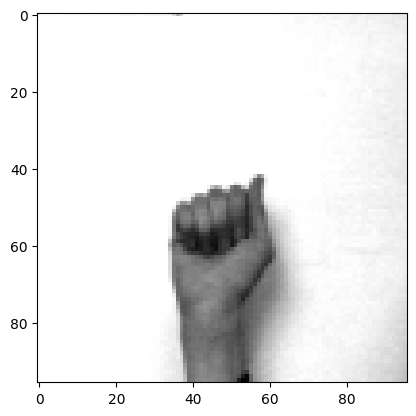

In [4]:
image = cv2.imread(DATASET_PATH_TEST_IMAGE)
image = cv2.resize(image,(96, 96))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap='gray')

Pre procesamiento

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

def apply_augmentation(X_train, y_train, augmentation_fraction=0.5):
    num_images = int(len(X_train) * augmentation_fraction)
    random_indices = random.sample(range(len(X_train)), num_images)

    augmented_images = []
    augmented_labels = []

    for index in random_indices:
        image = X_train[index].reshape((1, 96, 96, 1))
        label = y_train[index]

        for aug_image in datagen.flow(image, batch_size=1):
            augmented_images.append(aug_image[0])
            augmented_labels.append(label)
            break

    X_augmented = np.asarray(augmented_images)
    y_augmented = np.asarray(augmented_labels)

    X_train_augmented = np.concatenate((X_train, X_augmented), axis=0)
    y_train_augmented = np.concatenate((y_train, y_augmented), axis=0)

    return X_train_augmented, y_train_augmented

In [6]:
loaded_images = []
outputVectors = []
# list_of_gestures = ['1', "10", '2', '3', '4', '5', "Blank"] # Dataset_v4.1
list_of_gestures = ['A', 'B', "Blank", "Five", "One", "Three", "Two"] # Dataset_v2_specific

for gesture_index, gesture in enumerate(list_of_gestures):
    dataset_path = f"{DATASET_PATH}/{gesture}"
    gesture_path = os.path.join(dataset_path, '*')
    gest_path = glob.glob(gesture_path)

    for image_path in gest_path:
        image = cv2.imread(image_path)
        if image is not None:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image = cv2.resize(gray_image, (96, 96))
            loaded_images.append(gray_image)
            outputVector = [0] * len(list_of_gestures)
            outputVector[gesture_index] = 1
            outputVectors.append(outputVector)

print(f"Número total de imágenes cargadas: {len(loaded_images)}")
print(f"Número total de vectores de salida: {len(outputVectors)}\n")

X = np.asarray(loaded_images)
y = np.asarray(outputVectors)
print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}\n")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train = X_train.reshape(X_train.shape[0], 96, 96, 1)
X_test = X_test.reshape(X_test.shape[0], 96, 96, 1)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}\n")

X_train_augmented, y_train_augmented = apply_augmentation(X_train, y_train, augmentation_fraction=0.5)
X_test_augmented, y_test_augmented = apply_augmentation(X_test, y_test, augmentation_fraction=0.5)

print(f"Forma de X_train después de augmentation: {X_train_augmented.shape}")
print(f"Forma de y_train después de augmentation: {y_train_augmented.shape}")
print(f"Forma de X_test después de augmentation: {X_test_augmented.shape}")
print(f"Forma de y_test después de augmentation: {y_test_augmented.shape}")

Número total de imágenes cargadas: 10980
Número total de vectores de salida: 10980

Forma de X: (10980, 96, 96)
Forma de y: (10980, 7)

Forma de X_train: (8784, 96, 96, 1)
Forma de X_test: (2196, 96, 96, 1)
Forma de y_train: (8784, 7)
Forma de y_test: (2196, 7)

Forma de X_train después de augmentation: (13176, 96, 96, 1)
Forma de y_train después de augmentation: (13176, 7)
Forma de X_test después de augmentation: (3294, 96, 96, 1)
Forma de y_test después de augmentation: (3294, 7)


## CNN MODEL

In [83]:
model = tf.keras.Sequential([
    # tf.keras.layers.InputLayer(input_shape=(96, 96, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(384, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(192, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/home/benja/Documents/University_studies/Proyecto_de_Desarrollo_de_Software_ICC4201/P3/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 94, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 96)       │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 96)       │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 1, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 384)            │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 192)            │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,08

 Total params: 283,207 (1.08 MB)

 Trainable params: 283,207 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [84]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_augmented, y_train_augmented,
          batch_size=128,
          epochs=200,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping_callback])

Epoch 1/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 33s 297ms/step - accuracy: 0.1723 - loss: 0.5644 - val_accuracy: 0.2386 - val_loss: 0.4425
Epoch 2/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 289ms/step - accuracy: 0.2122 - loss: 0.4145 - val_accuracy: 0.2386 - val_loss: 0.4234
Epoch 3/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 288ms/step - accuracy: 0.2284 - loss: 0.4052 - val_accuracy: 0.3689 - val_loss: 0.3588
Epoch 4/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 290ms/step - accuracy: 0.3625 - loss: 0.3512 - val_accuracy: 0.6207 - val_loss: 0.2618
Epoch 5/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 290ms/step - accuracy: 0.5511 - loss: 0.2727 - val_accuracy: 0.7737 - val_loss: 0.1546
Epoch 6/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 289ms/step - accuracy: 0.6933 - loss: 0.2021 - val_accuracy: 0.8342 - val_loss: 0.1192
Epoch 7/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 290ms/step - accuracy: 0.7666 - loss: 0.1614 - val_accuracy: 0.8789 - val_loss: 0.0840
Epoch 8/200
103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 290ms/step - accuracy: 0.8161 -

Guardar

In [85]:
model.save(MODEL_PATH)

## Información

Evaluar el modelo

In [86]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy: " + str(acc))
model.summary()

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9357 - loss: 0.0534
Accuracy: 0.9426229596138


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 94, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 96)       │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 96)       │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 1, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 384)            │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 192)            │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,08

 Total params: 849,623 (3.24 MB)

 Trainable params: 283,207 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 566,416 (2.16 MB)

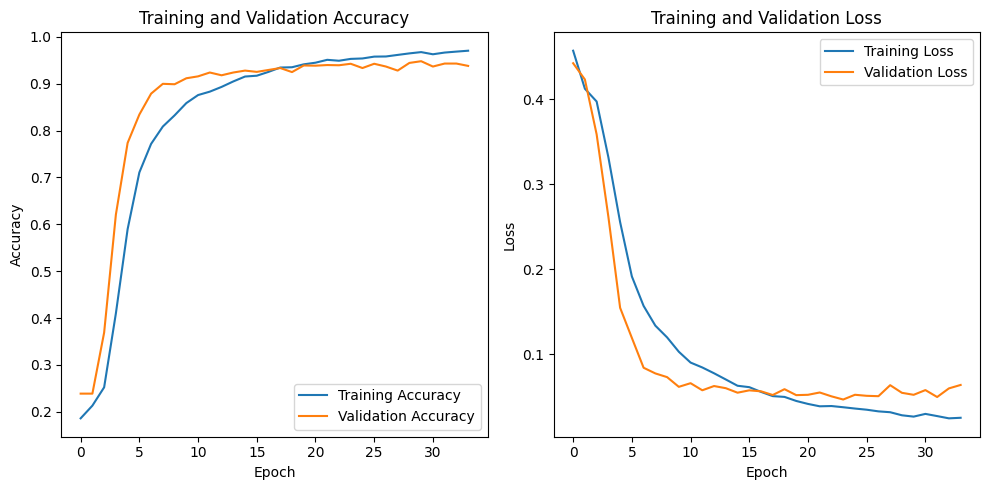

In [87]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_accuracy_loss(history)

## Predicciones del modelo

In [88]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy: " + str(acc))
print("Testing Accuracy:", acc)

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9357 - loss: 0.0534
Accuracy: 0.9426229596138
Testing Accuracy: 0.9426229596138


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


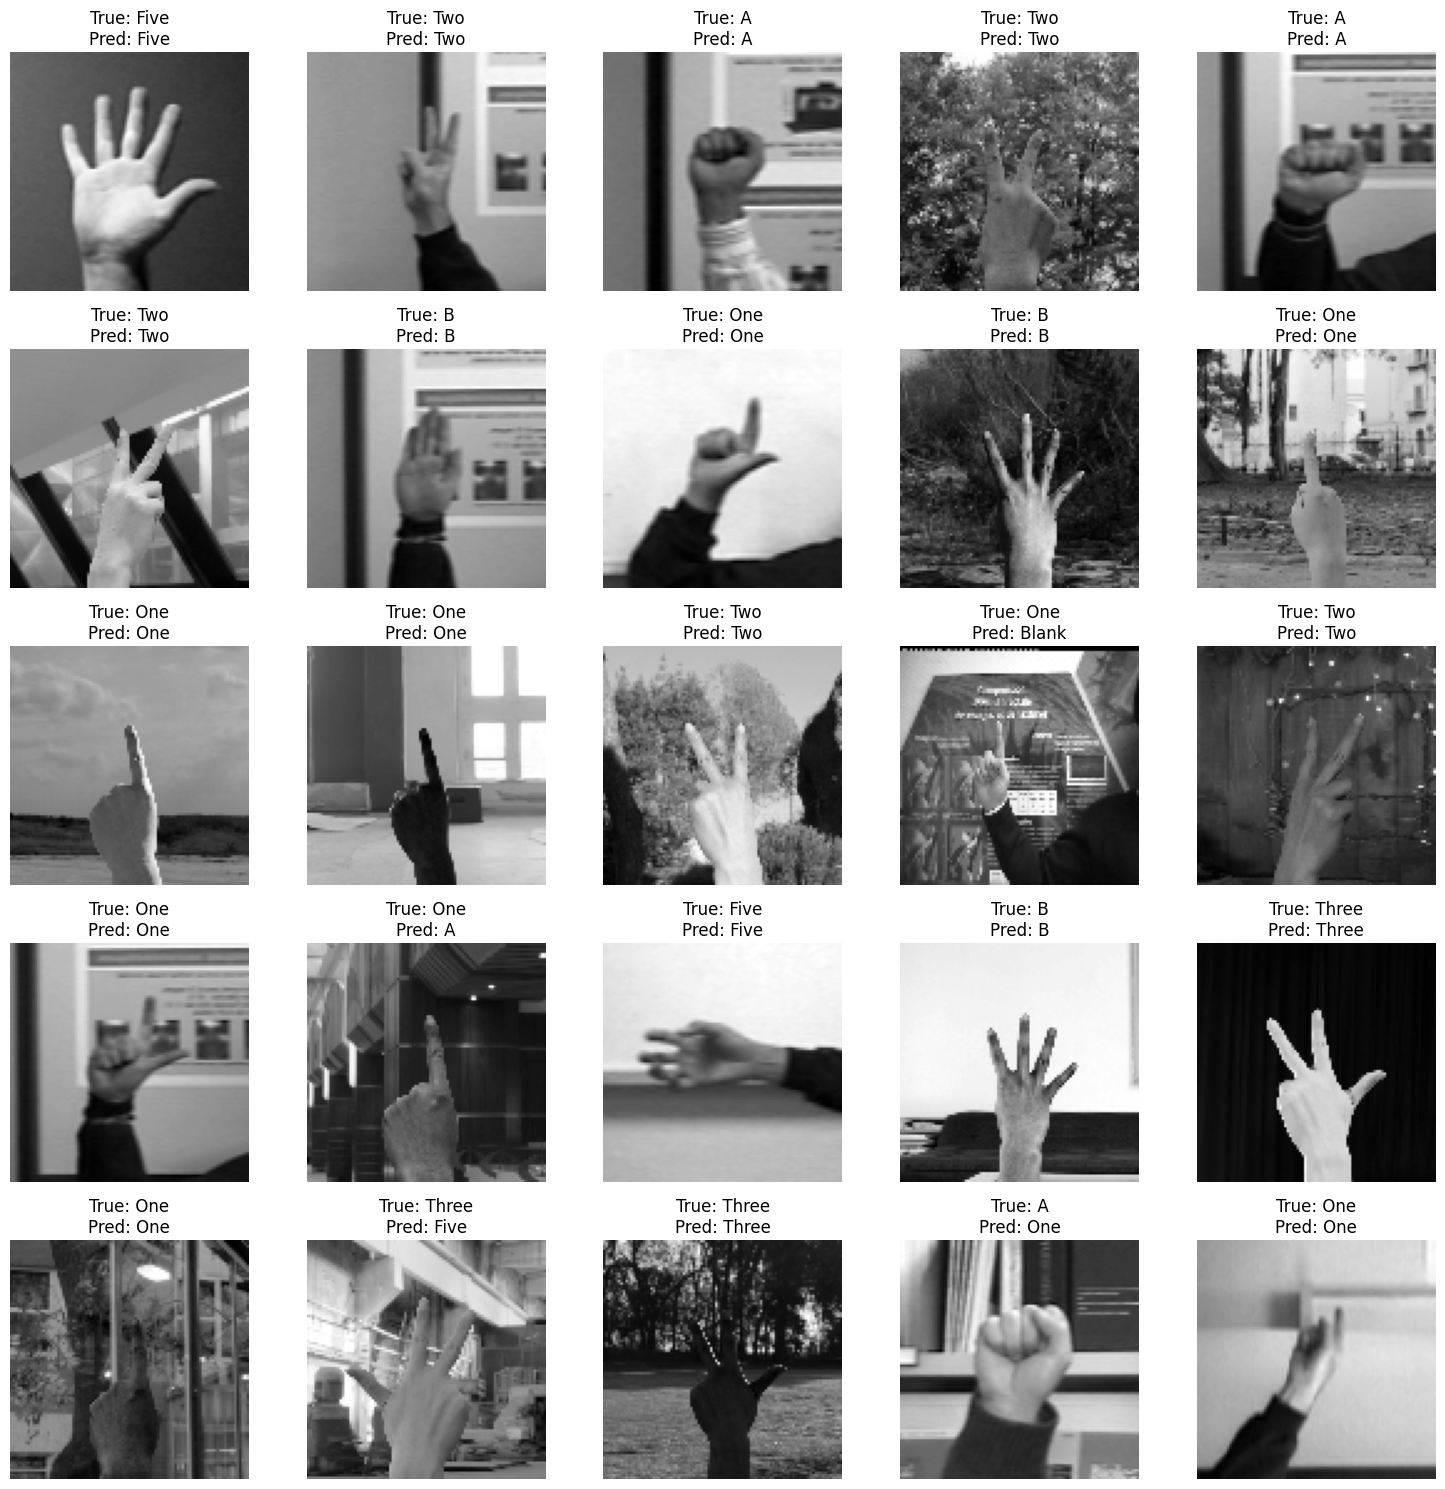

In [11]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

num_images_to_display = 25
plt.figure(figsize=(15, 15))

for i in range(num_images_to_display):
  plt.subplot(5, 5, i + 1)
  plt.imshow(X_test[i].reshape(96, 96), cmap='gray')
  plt.title(f"True: {list_of_gestures[y_true_classes[i]]}\nPred: {list_of_gestures[y_pred_classes[i]]}")
  plt.axis('off')

plt.tight_layout()
plt.show()

# CUANTIZACIÓN

In [8]:
model = tf.keras.models.load_model(MODEL_PATH)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter._experimental_disable_per_channel_quantization_for_dense_layers = True

converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset():
    for i in range(len(X_train_augmented)):
        image = X_train_augmented[i].reshape(1, 96, 96, 1)
        yield [image.astype(np.float32)]

converter.representative_dataset = representative_dataset

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

quantized_tflite_model = converter.convert()

with open(QUANTIZED_MODEL_PATH, 'wb') as f: f.write(quantized_tflite_model)
print(f"Modelo cuantizado guardado exitosamente como '{QUANTIZED_MODEL_PATH}'.")

INFO:tensorflow:Assets written to: /tmp/tmpnheybbk1/assets


INFO:tensorflow:Assets written to: /tmp/tmpnheybbk1/assets


Saved artifact at '/tmp/tmpnheybbk1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  127060331029200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127060331030352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127060331029584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127060331026896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127060332118096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127060501423952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127060216799952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127060216800720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127060216800912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127060216801872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127060216802832

/home/benja/Documents/University_studies/Proyecto_de_Desarrollo_de_Software_ICC4201/P3/venv/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1729540058.976773  311719 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1729540058.976788  311719 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-21 16:47:38.976930: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpnheybbk1
2024-10-21 16:47:38.977812: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-21 16:47:38.977827: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpnheybbk1
2024-10-21 16:47:38.986896: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-21 16:47:39.046268: I tensorflow/cc/saved_model/loader.cc:2

Modelo cuantizado guardado exitosamente como './models/quant_model_v2.tflite'.


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [9]:
interpreter = tf.lite.Interpreter(model_path=QUANTIZED_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_image(image):
    image = image.astype(np.uint8)
    image = image.reshape(1, 96, 96, 1)
    return image

def evaluate_model(interpreter, test_images, test_labels):
    total_seen = 0
    num_correct = 0

    for i in range(len(test_images)):
        input_data = preprocess_image(test_images[i])
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output_data)
        if predicted_label == np.argmax(test_labels[i]): num_correct += 1
        total_seen += 1

    accuracy = num_correct / total_seen
    print(f"Precisión del modelo cuantizado: {accuracy:.4f}")

evaluate_model(interpreter, X_test, y_test)

model_size = os.path.getsize(QUANTIZED_MODEL_PATH)
print(f"Tamaño del modelo cuantizado: {model_size / 1024:.2f} KB")  # Mostrar en kilobytes

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Precisión del modelo cuantizado: 0.9390
Tamaño del modelo cuantizado: 296.28 KB


## Predicciones del modelo cuantizado

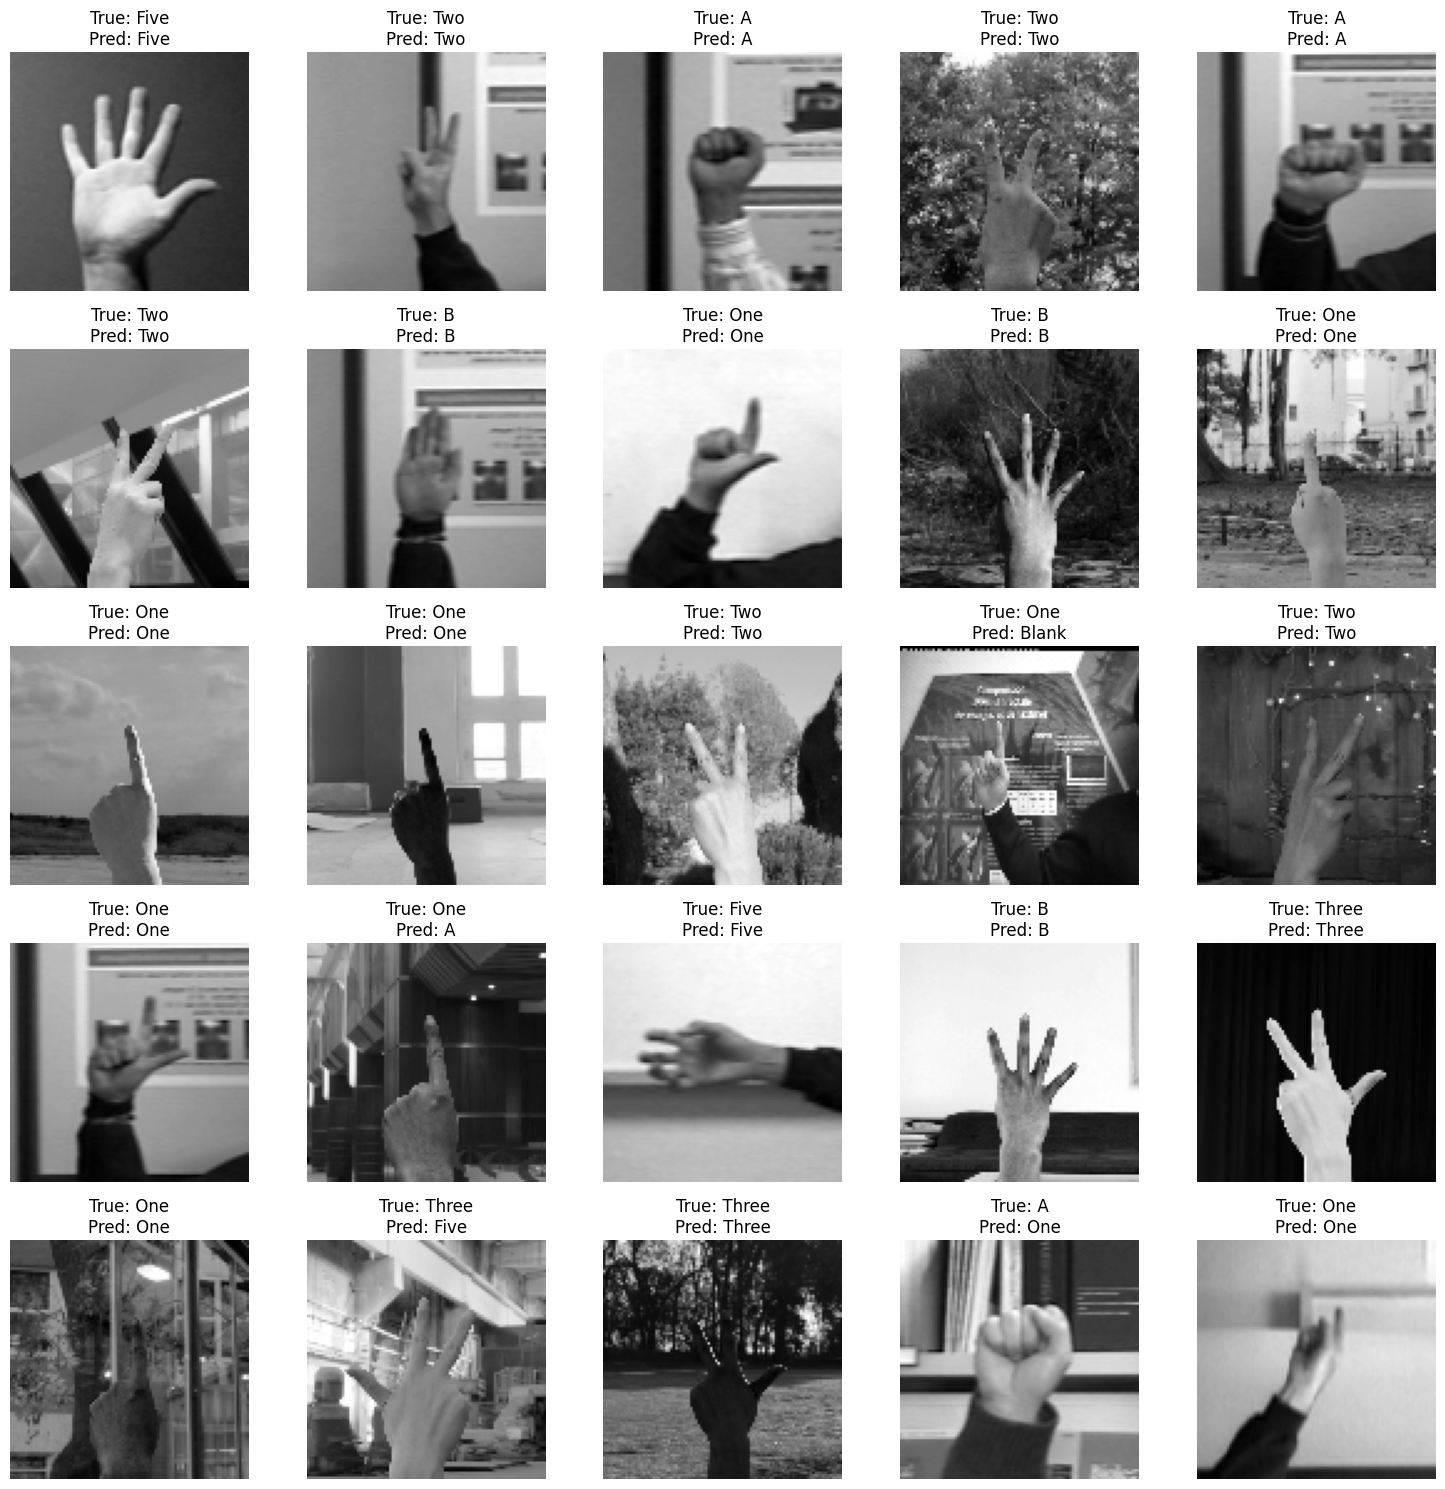

In [12]:
num_images_to_display = 25
plt.figure(figsize=(15, 15))

for i in range(num_images_to_display):
  plt.subplot(5, 5, i + 1)
  plt.imshow(X_test[i].reshape(96, 96), cmap='gray')
  plt.title(f"True: {list_of_gestures[y_true_classes[i]]}\nPred: {list_of_gestures[y_pred_classes[i]]}")
  plt.axis('off')

plt.tight_layout()
plt.show()

## Precision por clase

In [13]:
interpreter = tf.lite.Interpreter(model_path=QUANTIZED_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_image(image):
    image = image.astype(np.uint8)
    image = image.reshape(1, 96, 96, 1)
    return image

def evaluate_model(interpreter, test_images, test_labels):
    total_seen = 0
    num_correct = 0
    class_correct = np.zeros(test_labels.shape[1])
    class_total = np.zeros(test_labels.shape[1])

    for i in range(len(test_images)):
        input_data = preprocess_image(test_images[i])
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output_data)
        true_label = np.argmax(test_labels[i])
        if predicted_label == true_label:
            num_correct += 1
            class_correct[true_label] += 1
        class_total[true_label] += 1
        total_seen += 1

    accuracy = num_correct / total_seen
    print(f"Precisión del modelo cuantizado: {accuracy:.4f}")

    for i, (correct, total) in enumerate(zip(class_correct, class_total)):
        if total > 0:
            class_accuracy = correct / total
            print(f"Precisión para clase {i}: {class_accuracy:.4f} (Correctos: {int(correct)}, Total: {int(total)})")
        else: print(f"Clase {i} no tiene ejemplos en el conjunto de prueba.")

evaluate_model(interpreter, X_test, y_test)

model_size = os.path.getsize(QUANTIZED_MODEL_PATH)
print(f"Tamaño del modelo cuantizado: {model_size / 1024:.2f} KB")

Precisión del modelo cuantizado: 0.9390
Precisión para clase 0: 0.9829 (Correctos: 288, Total: 293)
Precisión para clase 1: 0.9454 (Correctos: 329, Total: 348)
Precisión para clase 2: 0.9310 (Correctos: 162, Total: 174)
Precisión para clase 3: 0.9363 (Correctos: 338, Total: 361)
Precisión para clase 4: 0.9294 (Correctos: 487, Total: 524)
Precisión para clase 5: 0.9438 (Correctos: 168, Total: 178)
Precisión para clase 6: 0.9119 (Correctos: 290, Total: 318)
Tamaño del modelo cuantizado: 296.28 KB


# HEXADECIMAL

In [15]:
!xxd -i {QUANTIZED_MODEL_PATH} > {HEX_MODEL_PATH}